# Belgium Rail Network EDA
Exploring GTFS data for NMBS/SNCB rail network.

### Importing Libraries

In [1]:
# Import libraries
import networkx as nx
import pandas as pd
import partridge as ptg
import folium
import matplotlib.pyplot as plt
from partridge import load_feed
import contextily as ctx
import geopandas as gpd

### Stops

In [2]:
gtfs_path = "data"  # Path to your data folder
feed = load_feed(gtfs_path)
stops = feed.stops

m = folium.Map(location=[50.85, 4.35], zoom_start=8)  # Centered on Belgium
for _, stop in stops.iterrows():
    folium.CircleMarker(
        location=[stop["stop_lat"], stop["stop_lon"]],
        radius=2,
        popup=stop["stop_name"],
        color="blue",
        fill=True
    ).add_to(m)
m.save("plots/belgium_stations_map.html")
print("Map saved as 'belgium_stations_map.html'.")

Map saved as 'belgium_stations_map.html'.


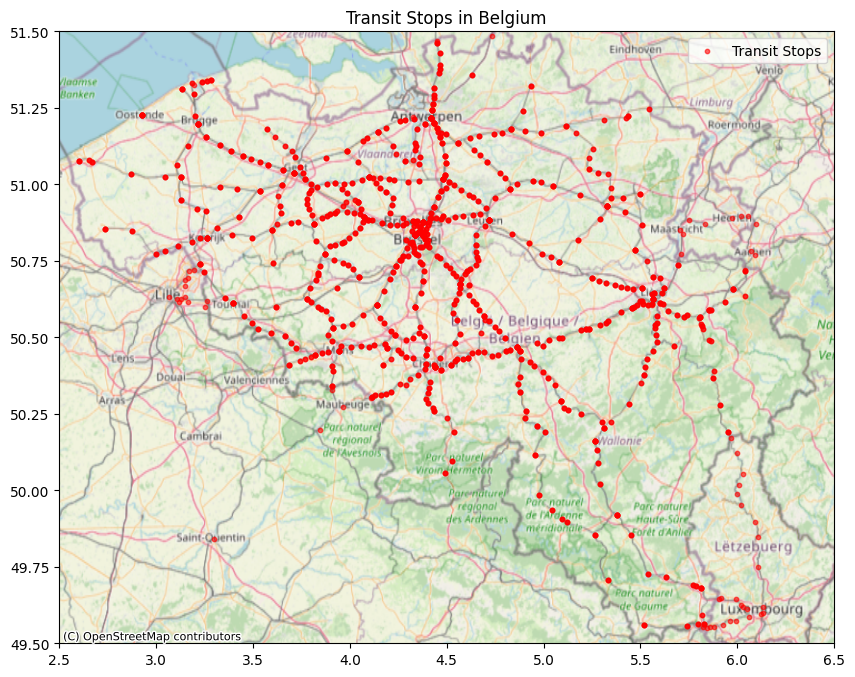

In [3]:
gtfs_path = "data"  # Path to your data folder
feed = load_feed(gtfs_path)
stops = feed.stops

# Convert stops to GeoDataFrame
gdf = gpd.GeoDataFrame(
    stops, 
    geometry=gpd.points_from_xy(stops["stop_lon"], stops["stop_lat"])
)
gdf = gdf.set_crs("EPSG:4326")

# Define Belgium bounds (approximate in WGS84)
minx, maxx, miny, maxy = 2.5, 6.5, 49.5, 51.5  # Lon, Lon, Lat, Lat for Belgium

# Create a plot with bounds
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color="red", markersize=10, alpha=0.6, label="Transit Stops")

# Add basemap with Belgium bounds
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, zoom=8)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.title("Transit Stops in Belgium")
plt.legend()
plt.show()  # This will display a static map showing only the Belgian region with stops overlaid

### Routes

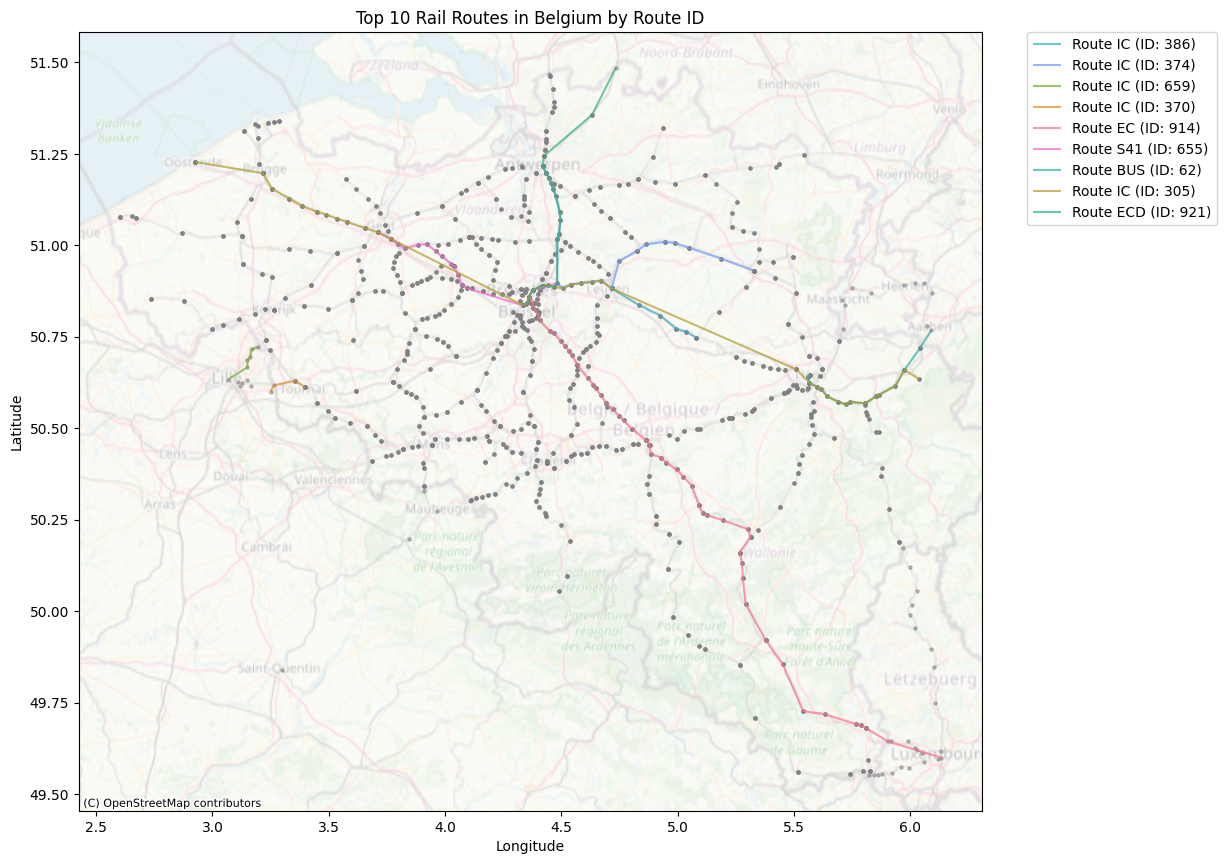

In [24]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx

# Load GTFS data
gtfs_path = "C:/Users/KIIT/Downloads/belgium-rail-gtfs/data"  # Path to your data folder
stops = pd.read_csv(f"{gtfs_path}/stops.txt")
trips = pd.read_csv(f"{gtfs_path}/trips.txt")
stop_times = pd.read_csv(f"{gtfs_path}/stop_times.txt")
routes = pd.read_csv(f"{gtfs_path}/routes.txt")

# Clean stops data: Remove rows with NaN or extreme values in lat/lon
stops_clean = stops.dropna(subset=['stop_lat', 'stop_lon'])
stops_clean = stops_clean[(stops_clean['stop_lat'].between(49.5, 51.5)) & (stops_clean['stop_lon'].between(2.5, 6.5))]

# Create a GeoDataFrame for stops
geometry = [Point(xy) for xy in zip(stops_clean['stop_lon'], stops_clean['stop_lat'])]
gdf_stops = gpd.GeoDataFrame(stops_clean, geometry=geometry, crs="EPSG:4326")

# Function to create route lines
def create_route_lines(route_id):
    # Get trips for this route
    route_trips = trips[trips['route_id'] == route_id]
    if route_trips.empty:
        return None
    
    # Take the first trip (simplification—could aggregate all trips)
    trip_id = route_trips['trip_id'].iloc[0]
    trip_stops = stop_times[stop_times['trip_id'] == trip_id].sort_values('stop_sequence')
    
    # Get stop coordinates in order
    stop_coords = []
    for stop_id in trip_stops['stop_id']:
        stop = stops_clean[stops_clean['stop_id'] == stop_id]
        if not stop.empty:
            stop_coords.append((stop['stop_lon'].iloc[0], stop['stop_lat'].iloc[0]))
    
    if len(stop_coords) < 2:  # Need at least 2 points for a line
        return None
    
    return LineString(stop_coords)

# Create a GeoDataFrame for routes with route_id
route_lines = []
route_ids = []
for route_id in routes['route_id'].unique():
    line = create_route_lines(route_id)
    if line is not None:
        route_lines.append(line)
        route_ids.append(route_id)

gdf_routes = gpd.GeoDataFrame({
    'route_id': route_ids,
    'geometry': route_lines
}, crs="EPSG:4326")

# Get the top 10 routes by trip count for coloring and legend
top_routes = trips['route_id'].value_counts().head(10).index
gdf_routes_top = gdf_routes[gdf_routes['route_id'].isin(top_routes)]

# Generate a color palette for the top 10 routes
n_routes = len(top_routes)
colors = sns.color_palette('husl', n_colors=n_routes)  # Use 'husl' for distinct, vibrant colors

# Create a color map for route_ids (only for top 10 routes) with route names for legend
route_names = {rid: routes[routes['route_id'] == rid]['route_short_name'].iloc[0] if not routes[routes['route_id'] == rid].empty else rid 
               for rid in top_routes}
color_map = {route_id: colors[i] for i, route_id in enumerate(top_routes)}
route_colors = [color_map.get(route_id, 'gray') for route_id in gdf_routes_top['route_id']]

# Plot the routes with different colors by route_id (for top 10 only)
plt.figure(figsize=(12, 10))

# Plot only the top routes with a custom legend
for idx, (route_id, group) in enumerate(gdf_routes_top.groupby('route_id')):
    group.plot(
        ax=plt.gca(),
        color=color_map[route_id],
        linewidth=1.5,
        alpha=0.7,
        label=f"Route {route_names[route_id]} (ID: {route_id})"
    )

# Add stops as points (optional, for context)
gdf_stops.plot(ax=plt.gca(), marker='o', color='grey', markersize=5, alpha=0.5)

plt.title('Top 10 Rail Routes in Belgium by Route ID')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add a dimmed basemap for better route visibility
ctx.add_basemap(plt.gca(), crs=gdf_routes.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.3)  # Dimmed with alpha=0.3

# Customize legend to link colors to route IDs and names
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:n_routes], [f"Route {route_names[rid]} (ID: {rid})" for rid in top_routes], 
           loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.tight_layout()
plt.savefig('plots/route_map_geopandas_by_routeid_with_legend.png')
plt.show()

In [23]:
from partridge import load_feed
import folium
from shapely.geometry import LineString
import pandas as pd

gtfs_path = "data"  # Path to your data folder
feed = load_feed(gtfs_path)
stops = feed.stops
trips = feed.trips
stop_times = feed.stop_times
routes = feed.routes
shapes = getattr(feed, 'shapes', None)  # Optional: Use shapes if available

# Clean data: Remove rows with NaN or extreme values in lat/lon
stops = stops.dropna(subset=["stop_lat", "stop_lon"])
stops = stops[(stops["stop_lat"].between(49.5, 51.5)) & (stops["stop_lon"].between(2.5, 6.5))]

# Create routes using stop sequences and optionally shapes
all_routes = []

for route_id, route_group in trips.groupby("route_id"):
    if route_id in routes.index:  # Ensure route exists
        for trip_id in route_group.index:
            if trip_id in stop_times.index:
                trip_stop_times = stop_times.loc[trip_id].sort_values("stop_sequence")
                coords = [(stops.loc[sid, "stop_lat"], stops.loc[sid, "stop_lon"]) 
                          for sid in trip_stop_times["stop_id"] if sid in stops.index and not pd.isna(sid)]
                
                if len(coords) > 1:
                    # Try to use shapes if available for more accurate routes
                    if shapes is not None and trip_id in shapes.index:
                        shape_points = shapes.loc[trip_id].sort_values("shape_pt_sequence")
                        shape_coords = [(pt["shape_pt_lat"], pt["shape_pt_lon"]) 
                                        for _, pt in shape_points.iterrows() if not pd.isna(pt["shape_pt_lat"])]
                        if len(shape_coords) > 1:
                            all_routes.append((LineString(shape_coords), routes.loc[route_id, "route_short_name"]))
                    else:
                        all_routes.append((LineString(coords), routes.loc[route_id, "route_short_name"]))

# Create an interactive map centered on Belgium
m = folium.Map(location=[50.5, 4.5], zoom_start=8)  # Centered on Belgium

# Add stops as markers
for _, stop in stops.iterrows():
    folium.CircleMarker(
        location=[stop["stop_lat"], stop["stop_lon"]],
        radius=3,
        popup=stop["stop_name"],
        color="red",
        fill=True,
        fill_color="red"
    ).add_to(m)

# Add routes as polylines
if all_routes:
    for route_geom, route_name in all_routes:
        coords = list(route_geom.coords)
        folium.PolyLine(
            locations=coords,
            color="blue",
            weight=2,
            opacity=0.7,
            popup=f"Route: {route_name}"
        ).add_to(m)
else:
    print("No valid routes found")

# Save the map
m.save("plots/belgium_transit_map.html")
print("Interactive map saved as 'belgium_transit_map.html'.")

No valid routes found
Interactive map saved as 'belgium_transit_map.html'.
